In [7]:

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Download latest version of the dataset and save the path in which it was downloaded to
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")  



In [8]:
#Read in the heart data
heart_data = pd.read_csv(f"{path}/heart.csv")

heart_data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
#First the one hot encoder needs to be applied to the columns
#ChestPainType, RestingECG, ST_Slope

new_encoder = OneHotEncoder()
encoded_heart = new_encoder.fit_transform(heart_data[["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]]).toarray()
print(encoded_heart)

heart_data['Sex'] = encoded_heart[:, 0]
heart_data['ChestPainType'] = encoded_heart[:, 1]
heart_data['RestingECG'] = encoded_heart[:, 2]
heart_data['ExerciseAngina'] = encoded_heart[:, 3]
heart_data['ST_Slope'] = encoded_heart[:, 4]
#As a sanity check to make sure all values are numeric
heart_data = heart_data.astype(float)
heart_data.head()

[[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 1. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40.0,0.0,1.0,140.0,289.0,0.0,0.0,172.0,1.0,0.0,0.0,0.0
1,49.0,1.0,0.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0,1.0,1.0
2,37.0,0.0,1.0,130.0,283.0,0.0,0.0,98.0,1.0,0.0,0.0,0.0
3,48.0,1.0,0.0,138.0,214.0,0.0,1.0,108.0,0.0,1.5,0.0,1.0
4,54.0,0.0,1.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0,1.0,0.0


In [10]:
#Next the training splits need to be made
target = heart_data['HeartDisease']
x_data = heart_data.drop(columns="HeartDisease")

x_train, x_test, y_train, y_test = train_test_split(x_data, target)


In [11]:
#Now apply the standard scaler to the x_train data

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

100%|██████████| 99/99 [01:29<00:00,  1.11it/s]


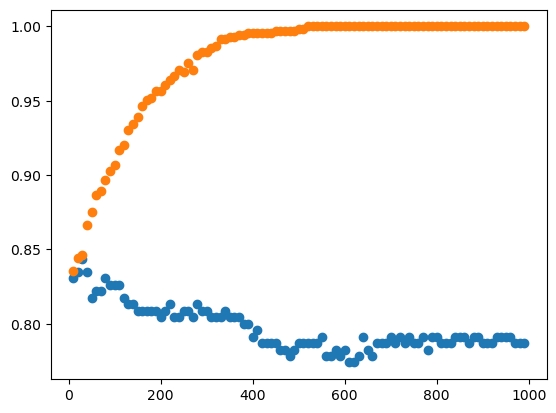

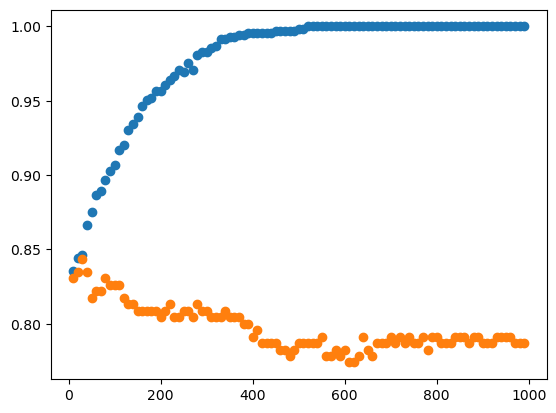

100%|██████████| 9/9 [00:00<00:00, 32.37it/s]


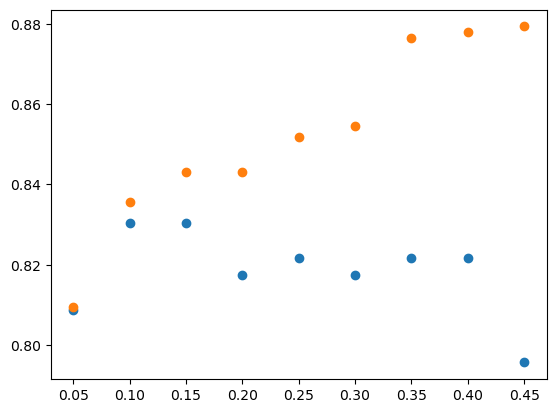

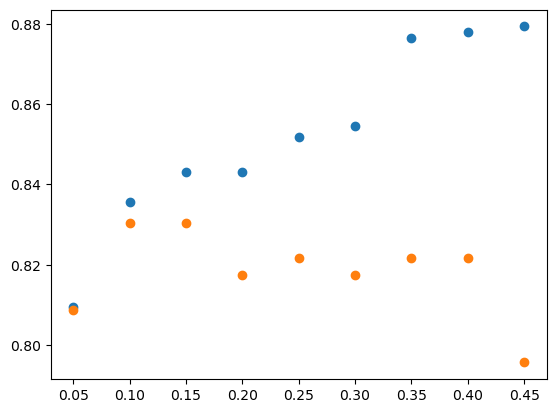

100%|██████████| 8/8 [00:00<00:00, 32.25it/s]


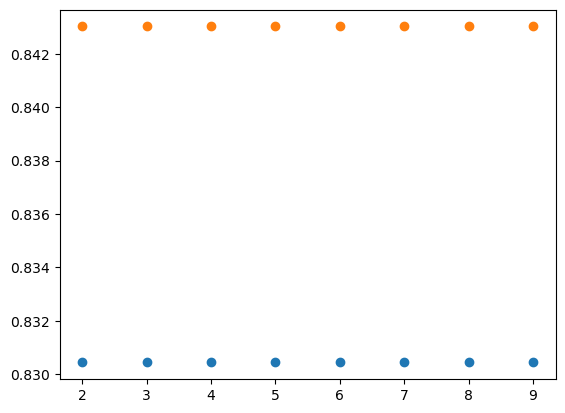

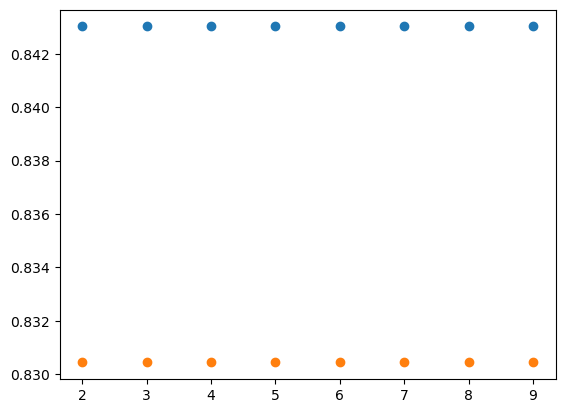

In [12]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = GradientBoostingClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = GradientBoostingClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = GradientBoostingClassifier(n_estimators=10, learning_rate=0.15, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()

In [ ]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = AdaBoostClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = AdaBoostClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []


  0%|          | 0/99 [00:00<?, ?it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
  2%|▏         | 2/99 [00:00<00:06, 13.89it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecat

In [ ]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = ExtraTreesClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = ExtraTreesClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = ExtraTreesClassifier(n_estimators=10, learning_rate=0.15, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()

In [ ]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = RandomForestClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = RandomForestClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = RandomForestClassifier(n_estimators=10, learning_rate=0.15, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()

In [ ]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = HistGradientBoostingClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = HistGradientBoostingClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = HistGradientBoostingClassifier(n_estimators=10, learning_rate=0.15, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train, y_train)
        testing_scores.append(classy.score(x_test, y_test))
        training_scores.append(classy.score(x_train, y_train))
        y_pred_train = classy.predict(x_train)
        y_pred_test = classy.predict(x_test)
        testing_accuracy.append(accuracy_score(y_test, y_pred_test))
        training_accuracy.append(accuracy_score(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()